In [46]:
import numpy as np
import pandas as pd 
import os
import re
import ast
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
import seaborn as sns
import spacy
nlp = spacy.load('en_core_web_sm')


from termcolor import colored
from IPython.display import Markdown
from wordcloud import WordCloud,STOPWORDS
from spacy import displacy

import warnings
warnings.filterwarnings("ignore")

In [2]:
# https://github.com/Alexis-benoist/eralchemy
#! pip install eralchemy

## Load dataset

This problem are composed of three main dataset - train, patient_notes and features - which are related as the it showed in DER graph below

![DER](/Users/galissa/Code/kaggle/nbme-score-clinical-patient-notes/der.png)

In [3]:
FILE_PATH = "/Users/galissa/Code/kaggle/nbme-score-clinical-patient-notes/data/raw/"
features_df = pd.read_csv(FILE_PATH + "features.csv")
patient_notes_df = pd.read_csv(FILE_PATH + "patient_notes.csv")
train_df = pd.read_csv(FILE_PATH + "train.csv")
test_df = pd.read_csv(FILE_PATH + "test.csv")
submission_df = pd.read_csv(FILE_PATH + "sample_submission.csv")


## Training Data


    


#### train.csv 

Feature annotations for 1000 of the patient notes, 100 for each of ten cases.
- id : Unique identifier for each patient note / feature pair.
- case_num : The case to which this patient note belongs.
- pn_num : The patient note annotated in this row.
- feature_num : The feature annotated in this row.
- annotation : The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.
- location : Character spans indicating the location of each annotation within the note. Multiple spans may be needed to represent an annotation, in which case the spans are delimited by a semicolon ;.

In [4]:
train_df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [5]:
train_df.shape

(14300, 6)

In [6]:
train_df.nunique()

id             14300
case_num          10
pn_num          1000
feature_num      143
annotation      5201
location        7534
dtype: int64

Feature_num has a range of value from 0 to 18 at the most for each case number. It increases to a hundred when case number increases an unit.

In [10]:
train_df.groupby('case_num').agg({'id':['count',pd.Series.nunique],'pn_num': [pd.Series.nunique], 'feature_num': ["min", "max",pd.Series.nunique]})

id          pn_num feature_num             
         count nunique nunique         min  max nunique
case_num                                               
0         1300    1300     100           0   12      13
1         1300    1300     100         100  112      13
2         1700    1700     100         200  216      17
3         1600    1600     100         300  315      16
4         1000    1000     100         400  409      10
5         1800    1800     100         500  517      18
6         1200    1200     100         600  611      12
7          900     900     100         700  708       9
8         1800    1800     100         800  817      18
9         1700    1700     100         900  916      17

In [11]:
train_df.dtypes

id             object
case_num        int64
pn_num          int64
feature_num     int64
annotation     object
location       object
dtype: object

From the example below, we can notice that each patient has many anotation that belong to diferents students and it goes from 0 to 8

In [7]:
train_df[train_df['pn_num']==16]

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']
5,00016_005,0,16,5,[],[]
6,00016_006,0,16,6,"['adderall', 'adderrall', 'adderrall']","['321 329', '404 413', '652 661']"
7,00016_007,0,16,7,[],[]
8,00016_008,0,16,8,[],[]
9,00016_009,0,16,9,"['palpitations', 'heart beating/pounding']","['26 38', '96 118']"


In [58]:
train_df[train_df['pn_num']==2436]

,id,case_num,pn_num,feature_num,annotation,location,count_annotation
1287,02436_000,0,2436,0,"['Father MI', 'father had a heart attack']","['915 924', '545 570']",2
1288,02436_001,0,2436,1,['Mother thyroid issues'],['893 914'],1
1289,02436_002,0,2436,2,[],[],0
1290,02436_003,0,2436,3,[],[],0
1291,02436_004,0,2436,4,[],[],0
1292,02436_005,0,2436,5,[],[],0
1293,02436_006,0,2436,6,['adderal'],['603 610'],1
1294,02436_007,0,2436,7,['shortness of breath'],['371 390'],1
1295,02436_008,0,2436,8,[],[],0
1296,02436_009,0,2436,9,"['chest palpitations', 'chest palpitations']","['71 89', '109 127']",2


In [57]:
train_df[train_df['case_num']==0]

,id,case_num,pn_num,feature_num,annotation,location,count_annotation
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],1
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],1
2,00016_002,0,16,2,['chest pressure'],['203 217'],1
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",2
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],1
...,...,...,...,...,...,...,...
1295,02436_008,0,2436,8,[],[],0
1296,02436_009,0,2436,9,"['chest palpitations', 'chest palpitations']","['71 89', '109 127']",2
1297,02436_010,0,2436,10,['2-3 month'],['50 59'],1
1298,02436_011,0,2436,11,['17 year old'],['26 37'],1


In [11]:
# number annotations
train_df['count_annotation'] = train_df['location'].apply(lambda x : ast.literal_eval(x).__len__())
train_df['count_annotation'].describe()

count    14300.000000
mean         0.855524
std          0.756237
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: count_annotation, dtype: float64

In [9]:
train_df[train_df['case_num']==0].pn_num.unique()

array([  16,   41,   46,   82,  100,  161,  188,  211,  224,  225,  234,
        331,  344,  352,  372,  390,  426,  464,  489,  495,  510,  575,
        583,  585,  625,  653,  669,  673,  699,  701,  719,  768,  769,
        777,  796,  804,  810,  816,  817,  821,  831,  861,  883,  970,
        977,  987, 1010, 1110, 1115, 1133, 1146, 1149, 1151, 1165, 1173,
       1186, 1200, 1209, 1235, 1250, 1264, 1270, 1281, 1318, 1376, 1512,
       1547, 1581, 1587, 1613, 1622, 1652, 1692, 1694, 1699, 1723, 1742,
       1809, 1835, 1847, 1855, 1881, 1939, 1948, 2078, 2151, 2163, 2184,
       2198, 2201, 2223, 2271, 2285, 2290, 2308, 2315, 2425, 2428, 2430,
       2436])

In [7]:
features_df[features_df['feature_num'].isin(train_df[train_df['case_num']==0].feature_num.unique().tolist())]

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded
5,5,0,No-hair-changes-OR-no-nail-changes-OR-no-tempe...
6,6,0,Adderall-use
7,7,0,Shortness-of-breath
8,8,0,Caffeine-use
9,9,0,heart-pounding-OR-heart-racing


In [6]:
features_df[features_df['feature_num'].isin(train_df[train_df['case_num']==1].feature_num.unique().tolist())]

,feature_num,case_num,feature_text
13,100,1,No-vaginal-discharge
14,101,1,Weight-loss
15,102,1,Not-sexually-active
16,103,1,Prior-episodes-of-diarrhea
17,104,1,20-year
18,105,1,No-bloody-bowel-movements
19,106,1,Recurrent-bouts-over-past-6-months
20,107,1,Right-sided-LQ-abdominal-pain-OR-Right-lower-q...
21,108,1,No-urinary-symptoms
22,109,1,Diminished-appetite


In [8]:
features_df[features_df['feature_num'].isin(train_df[train_df['case_num']==2].feature_num.unique().tolist())]

,feature_num,case_num,feature_text
26,200,2,Prior-normal-periods
27,201,2,Last-Pap-smear-I-year-ago
28,202,2,IUD
29,203,2,Sexually-active
30,204,2,Vaginal-dryness
31,205,2,Irregular-menses
32,206,2,Recent-nausea-vomiting-OR-Recent-flulike-symptoms
33,207,2,No-premenstrual-symptoms
34,208,2,Female
35,209,2,Stress


In [11]:
features_df.columns

Index(['feature_num', 'case_num', 'feature_text'], dtype='object')

####  Annotation by case_num

As we can see in the graph below, the mean of annotation is under 1 for most clinical cases, except for cases 4 and 7. Cases number 5 are those how have more number of annotation, and cases number 7 are those who have less number of annotation.  

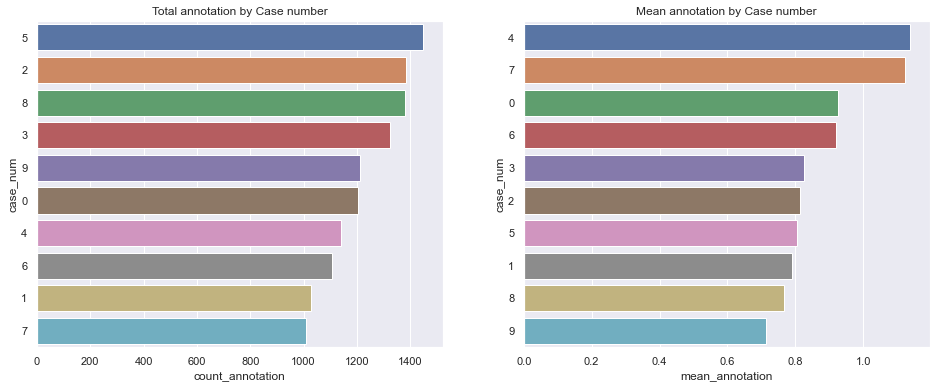

In [24]:
sns.set_theme()
count_annotation_case_df = train_df.groupby('case_num').agg(count_annotation=('count_annotation','sum')).reset_index()\
    .sort_values('count_annotation', ascending=False)

mean_annotation_case_df = train_df.groupby('case_num').agg(mean_annotation=('count_annotation','mean')).reset_index()\
    .sort_values('mean_annotation', ascending=False)



fig, ax =plt.subplots(1,2, figsize=(16,6))
sns.barplot(y="case_num", x="count_annotation", orient='h',  order=count_annotation_case_df.case_num.tolist(), data=count_annotation_case_df,ax=ax[0])\
    .set_title("Total annotation by Case number")

ax = sns.barplot(y="case_num", x="mean_annotation", orient='h',  order=mean_annotation_case_df.case_num.tolist(), data=mean_annotation_case_df, ax=ax[1])\
    .set_title("Mean annotation by Case number")


fig.show()

In [16]:
mean_annotation_case_df = train_df.groupby('case_num').agg({'count_annotation':'sum','pn_num':pd.Series.nunique}).reset_index()

In [17]:
mean_annotation_case_df

,case_num,count_annotation,pn_num
0,0,1203,100
1,1,1029,100
2,2,1384,100
3,3,1323,100
4,4,1139,100
5,5,1449,100
6,6,1105,100
7,7,1010,100
8,8,1379,100
9,9,1213,100


In [18]:
mean_annotation_case_df['count_annotation']/mean_annotation_case_df['pn_num']

0    12.03
1    10.29
2    13.84
3    13.23
4    11.39
5    14.49
6    11.05
7    10.10
8    13.79
9    12.13
dtype: float64

Doing the same analysis by patients number, in this case, we can see that most of annotation them are over 1.

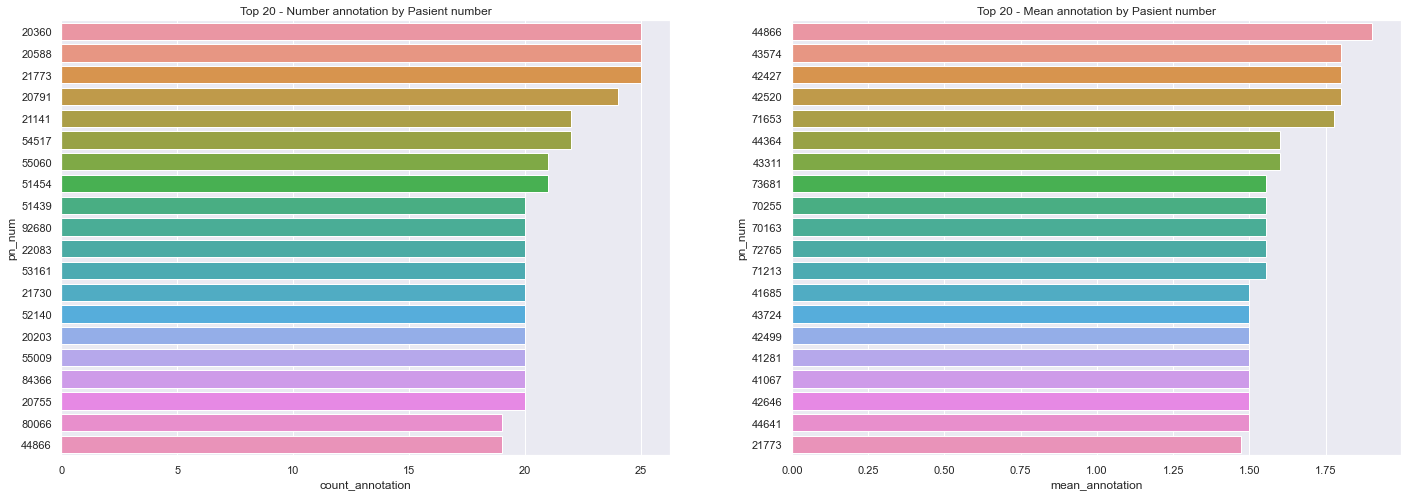

In [25]:
sns.set_theme()
mean_annotation_pn_df = train_df.groupby('pn_num').agg(mean_annotation=('count_annotation','mean')).reset_index()\
    .sort_values('mean_annotation', ascending=False)
mean_annotation_pn_df = mean_annotation_pn_df.iloc[:20,:]


count_annotation_pn_df = train_df.groupby('pn_num').agg(count_annotation=('count_annotation','sum')).reset_index()\
    .sort_values('count_annotation', ascending=False)
count_annotation_pn_df = count_annotation_pn_df.iloc[:20,:]


fig, ax =plt.subplots(1,2, figsize=(24,8))
sns.barplot(x="count_annotation", y="pn_num", orient='h', order=count_annotation_pn_df.pn_num.tolist(),data=count_annotation_pn_df,ax=ax[0])\
        .set_title("Top 20 - Number annotation by Pasient number")

sns.barplot(x="mean_annotation", y="pn_num", orient='h', order=mean_annotation_pn_df.pn_num.tolist(),data=mean_annotation_pn_df,ax=ax[1])\
        .set_title("Top 20 - Mean annotation by Pasient number")

fig.show()


### patient_notes.csv

A collection of about 40,000 Patient Note history portions. Only a subset of these have features annotated. <span style="color:orange">*You may wish to apply unsupervised learning techniques on the notes without annotations*</span>. The patient notes in the test set are not included in the public version of this file.
- pn_num - A unique identifier for each patient note.
- case_num - A unique identifier for the clinical case a patient note represents.
- pn_history - The text of the encounter as recorded by the test taker.

In [6]:
patient_notes_df.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [7]:
patient_notes_df.shape

(42146, 3)

In [8]:
patient_notes_df.nunique()

pn_num        42146
case_num         10
pn_history    42146
dtype: int64

In [43]:
patient_notes_df[patient_notes_df['pn_num']==16]['pn_history'].values

array(['HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms'],
      dtype=object)


### features.csv 

The rubric of features (or key concepts) for each clinical case.
- feature_num - A unique identifier for each feature.
- case_num - A unique identifier for each case.
- feature_text - A description of the feature.

The exam required test-takers to interact with Standardized Patients (people trained to portray specific clinical cases) and write a patient note. Trained physician raters later scored patient notes with rubrics that outlined each case’s important concepts (referred to as features). The more such features found in a patient note, the higher the score (among other factors that contribute to the final score for the exam).


In [31]:
features_df.head()

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [32]:
features_df.shape

(143, 3)

In [33]:
features_df.nunique()

feature_num     143
case_num         10
feature_text    131
dtype: int64

As you can se below, each case number has the same number of features --  "missing" ('[]') features included --

In [34]:
features_df.groupby('case_num').agg({ 'feature_num': ['count',pd.Series.nunique], 'feature_text': ['count',pd.Series.nunique]})

feature_num         feature_text        
               count nunique        count nunique
case_num                                         
0                 13      13           13      13
1                 13      13           13      13
2                 17      17           17      17
3                 16      16           16      16
4                 10      10           10      10
5                 18      18           18      18
6                 12      12           12      12
7                  9       9            9       9
8                 18      18           18      18
9                 17      17           17      17

Seems like the features in this competition are medical pieces of information that always appear in the same order for each case. In case a piece of information does not appear in the patient record that feature would be "missing" ('[]').

Let's see some pair of examples

In [35]:
features_df[features_df['case_num']==0]

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded
5,5,0,No-hair-changes-OR-no-nail-changes-OR-no-tempe...
6,6,0,Adderall-use
7,7,0,Shortness-of-breath
8,8,0,Caffeine-use
9,9,0,heart-pounding-OR-heart-racing


In [36]:
features_df[features_df['case_num']==5]

,feature_num,case_num,feature_text
69,500,5,Onset-5-years-ago
70,501,5,Female
71,502,5,No-caffeine-use
72,503,5,Associated-SOB-OR-Associated-shortness-of-breath
73,504,5,Episodes-of-heart-racing
74,505,5,Recent-visit-to-emergency-department-with-nega...
75,506,5,No-chest-pain
76,507,5,No-illicit-drug-use
77,508,5,Associated-nausea
78,509,5,Increased-frequency-recently


### Using Spacy to colored annotation and features with ent
Here we take each annotation position and they corresponding feature and color them in order to visualize every patient's annotation

In [88]:
def colored_patient_notes(pn_num):

    colors = {
        '0':'#0000FF',
        '1':'#BC8F8F', 
        '2':'#3d3d3d', 
        '3':'#CD5C5C', 
        '4':'#FA8072', 
        '5':'#CD853F', 
        '6':'#FFD700', 
        '7':'#FF8C00', 
        '8':'#F0E68C', 
        '9':'#BDB76B', 
        '10':'#32CD32', 
        '11':'#00FFFF', 
        '12':'#B0E0E6', 
        '13':'#87CEFA', 
        '14':'#B0C4DE', 
        '15':'#DDA0DD', 
        '16':'#EE82EE', 
        '17':'#FFC0CB'
        }

    ents = []
    feature_list = []
    for i, row in train_df[train_df['pn_num']==pn_num].iterrows(): 
        for loc in ast.literal_eval(row['location']):
            loc = loc.replace(';', ' ').replace(':', ' ')
            loc_splited = loc.split(' ')

            ents.append({
                'start': int(loc_splited[0]),
                'end': int(loc_splited[1]),
                'label': str(int(str(row['feature_num'])[-2:]))

            })

            feature_list.append(row['feature_num'])

    
    print("\nFeatures")
    print('='*80)

    
    for feature_num in set(feature_list):
        print(features_df[features_df['feature_num'] == feature_num]['feature_text'].values[0])
        try:
            #feature = features_df[features_df['feature_num'] == feature_num]['feature_text'][feature_num]
            feature = features_df[features_df['feature_num'] == feature_num]['feature_text'].values[0]
            #print(colored(feature, color='red'))
            display(Markdown(f'<span style="color: {colors[str(feature_num)[-2:]]}">{feature_num} : {feature}</span>'))
        except:
            print(colored("Upps Something is wrong! No features found. ", 'red'))
            pass
    
    print("\nPatient Notes")
    print('='*80)

    

    text = patient_notes_df[patient_notes_df['pn_num']==pn_num]['pn_history'].values[0]
    doc2 = {
        "text": text,
        "ents": ents,
    }

    
        
    options = {"ents": [ent['label'] for ent in ents], "colors": colors}
    spacy.displacy.render(doc2, style="ent", options=options, manual=True, jupyter=True);




In [89]:
colored_patient_notes(pn_num=16)



Features
Family-history-of-MI-OR-Family-history-of-myocardial-infarction


<span style="color: #0000FF">0 : Family-history-of-MI-OR-Family-history-of-myocardial-infarction</span>

Family-history-of-thyroid-disorder


<span style="color: #BC8F8F">1 : Family-history-of-thyroid-disorder</span>

Chest-pressure


<span style="color: #3d3d3d">2 : Chest-pressure</span>

Intermittent-symptoms


<span style="color: #CD5C5C">3 : Intermittent-symptoms</span>

Lightheaded


<span style="color: #FA8072">4 : Lightheaded</span>

Adderall-use


<span style="color: #FFD700">6 : Adderall-use</span>

heart-pounding-OR-heart-racing


<span style="color: #BDB76B">9 : heart-pounding-OR-heart-racing</span>

Few-months-duration


<span style="color: #32CD32">10 : Few-months-duration</span>

17-year


<span style="color: #00FFFF">11 : 17-year</span>

Male


<span style="color: #B0E0E6">12 : Male</span>


Patient Notes


In [91]:
colored_patient_notes(pn_num=34986)



Features
Epigastric-discomfort
Upps Something is wrong! No features found. 
Darker-bowel-movements
Upps Something is wrong! No features found. 
NSAID-use-OR-Nonsteroidal-anti-inflammatory-drug-use
Upps Something is wrong! No features found. 
burning-OR-gnawing-OR-burning-and-gnawing
Upps Something is wrong! No features found. 
getting-worse-OR-progressive-OR-symptoms-now-daily
Upps Something is wrong! No features found. 
2-to-3-beers-a-week
Upps Something is wrong! No features found. 
Male
Upps Something is wrong! No features found. 
duration-2-months
Upps Something is wrong! No features found. 
No-blood-in-stool


<span style="color: #00FFFF">311 : No-blood-in-stool</span>

Minimal-to-no-change-with-Tums


<span style="color: #87CEFA">313 : Minimal-to-no-change-with-Tums</span>

35-year


<span style="color: #DDA0DD">315 : 35-year</span>


Patient Notes


In [60]:
train_df[train_df['pn_num']==34986]

,id,case_num,pn_num,feature_num,annotation,location,count_annotation
5148,34986_300,3,34986,300,[],[],0
5149,34986_301,3,34986,301,['pain epidrual region'],['129 133;191 206'],1
5150,34986_302,3,34986,302,['darkening of stool'],['536 554'],1
5151,34986_303,3,34986,303,['motrin'],['782 788'],1
5152,34986_304,3,34986,304,['gnawing burning'],['158 173'],1
5153,34986_305,3,34986,305,[],[],0
5154,34986_306,3,34986,306,['getting worse'],['362 375'],1
5155,34986_307,3,34986,307,['drinks socially'],['904 919'],1
5156,34986_308,3,34986,308,"['Mr', 'male']","['0 2', '25 29']",2
5157,34986_309,3,34986,309,['with 2 months'],['93 106'],1


In [ ]:
train_df[train_df['pn_num']==34986]

In [62]:
features_df[features_df['case_num']==3]

,feature_num,case_num,feature_text
43,300,3,FHx-of-PUD-OR-Family-history-of-peptic-ulcer-d...
44,301,3,Epigastric-discomfort
45,302,3,Darker-bowel-movements
46,303,3,NSAID-use-OR-Nonsteroidal-anti-inflammatory-dr...
47,304,3,burning-OR-gnawing-OR-burning-and-gnawing
48,305,3,Post-prandial-bloating-OR-fullness-with-meals
49,306,3,getting-worse-OR-progressive-OR-symptoms-now-d...
50,307,3,2-to-3-beers-a-week
51,308,3,Male
52,309,3,duration-2-months


In [81]:

feature_list = [301, 302, 303, 304, 306, 307, 308, 308, 309, 311, 313, 315]

for feature_num in set(feature_list):
    print(feature_num)
    #print(features_df[features_df['feature_num'] == feature_num]['feature_text'].values[0])
    feature = features_df[features_df['feature_num'] == feature_num]['feature_text'].values[0]
    print(feature)
    #[feature_num])

301
Epigastric-discomfort
302
Darker-bowel-movements
303
NSAID-use-OR-Nonsteroidal-anti-inflammatory-drug-use
304
burning-OR-gnawing-OR-burning-and-gnawing
306
getting-worse-OR-progressive-OR-symptoms-now-daily
307
2-to-3-beers-a-week
308
Male
309
duration-2-months
311
No-blood-in-stool
313
Minimal-to-no-change-with-Tums
315
35-year


### Joining datasets

In [116]:
merge_df = pd.merge(train_df, patient_notes_df, how='left', on=['pn_num','case_num'])
merge_df = pd.merge(merge_df, features_df, how='left', on=['feature_num','case_num'])

In [117]:
merge_df.shape

(14300, 9)

In [119]:
merge_df.sample(3)

,id,case_num,pn_num,feature_num,annotation,location,count_annotation,pn_history,feature_text
5533,37240_301,3,37240,301,"['sensation in epigastric (""mid-chest"") area']",['101 143'],1,Mr. Hamilton is a 35 year old man presenting w...,Epigastric-discomfort
5161,34986_313,3,34986,313,['tums not working'],['461 465;497 508'],1,Mr. Hamilton is a 35 y/o male with PMHx signif...,Minimal-to-no-change-with-Tums
4532,31368_308,3,31368,308,"['Mr.', 'M']","['0 3', '23 24']",2,Mr. Hamilton is a 35yo M who presents to the c...,Male



### test.csv 

Example instances selected from the training set.
- id : Unique identifier for each patient note / feature pair.
- case_num : The case to which this patient note belongs.
- pn_num : The patient note annotated in this row.
- feature_num : The feature annotated in this row.

All of the patient notes (both train and test) are from the same ten clinical cases. (edit:) I've also added a clarification to the Data page.

In [9]:
test_df.head()

,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


In [10]:
test_df.shape

(5, 4)

In [12]:
test_df.nunique()

id             5
case_num       1
pn_num         1
feature_num    5
dtype: int64

### sample_submission.csv
A sample submission file in the correct format.


In [13]:
submission_df.head()

,id,location
0,00016_000,0 100
1,00016_001,NaN
2,00016_002,200 250;300 400
3,00016_003,NaN
4,00016_004,75 110


In [14]:
submission_df.shape

(5, 2)

In [15]:
submission_df.nunique()

id          5
location    3
dtype: int64